In [69]:
# import packages
import os
import pickle
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from sklearn.metrics.pairwise import cosine_similarity
from pathlib import Path
import seaborn as sns
from itertools import combinations
import pandas as pd
import nltk
from nltk.corpus import stopwords

In [71]:
# Download stopwords if not already present
try:
    stop_words = set(stopwords.words('english'))
except:
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))

# Additional stopwords specific to the domain
ADDITIONAL_STOPWORDS = {
    'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with', 'by', 'from', 
    'up', 'about', 'into', 'through', 'during', 'before', 'after', 'above', 'below',
    'the', 'a', 'an', 'this', 'that', 'these', 'those', 'my', 'your', 'his', 'her',
    'its', 'our', 'their', 'i', 'you', 'he', 'she', 'it', 'we', 'they', 'me', 'him',
    'her', 'us', 'them', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being',
    'have', 'has', 'had', 'do', 'does', 'did', 'will', 'would', 'could', 'should',
    'may', 'might', 'must', 'can', 'shall', 'get', 'got', 'go', 'goes', 'went',
    'come', 'came', 'take', 'took', 'taken', 'make', 'made', 'see', 'saw', 'seen',
    'know', 'knew', 'known', 'think', 'thought', 'say', 'said', 'tell', 'told',
    'ask', 'asked', 'give', 'gave', 'given', 'find', 'found', 'work', 'worked',
    'call', 'called', 'try', 'tried', 'need', 'needed', 'feel', 'felt', 'become',
    'became', 'leave', 'left', 'put', 'keep', 'kept', 'let', 'begin', 'began',
    'seem', 'seemed', 'help', 'helped', 'show', 'showed', 'shown', 'hear', 'heard',
    'play', 'played', 'run', 'ran', 'move', 'moved', 'live', 'lived', 'believe',
    'believed', 'hold', 'held', 'bring', 'brought', 'happen', 'happened', 'write',
    'wrote', 'written', 'provide', 'provided', 'sit', 'sat', 'stand', 'stood',
    'lose', 'lost', 'pay', 'paid', 'meet', 'met', 'include', 'included', 'continue',
    'continued', 'set', 'learn', 'learned', 'change', 'changed', 'lead', 'led',
    'understand', 'understood', 'watch', 'watched', 'follow', 'followed', 'stop',
    'stopped', 'create', 'created', 'speak', 'spoke', 'spoken', 'read', 'allow',
    'allowed', 'add', 'added', 'spend', 'spent', 'grow', 'grew', 'grown', 'open',
    'opened', 'walk', 'walked', 'win', 'won', 'offer', 'offered', 'remember',
    'remembered', 'love', 'loved', 'consider', 'considered', 'appear', 'appeared',
    'buy', 'bought', 'wait', 'waited', 'serve', 'served', 'die', 'died', 'send',
    'sent', 'expect', 'expected', 'build', 'built', 'stay', 'stayed', 'fall',
    'fell', 'fallen', 'cut', 'reach', 'reached', 'kill', 'killed', 'remain',
    'remained', 'suggest', 'suggested', 'raise', 'raised', 'pass', 'passed',
    'sell', 'sold', 'require', 'required', 'report', 'reported', 'decide',
    'decided', 'pull', 'pulled', 'return', 'returned', 'explain', 'explained',
    'hope', 'hoped', 'develop', 'developed', 'carry', 'carried', 'break', 'broke',
    'broken', 'receive', 'received', 'agree', 'agreed', 'support', 'supported',
    'hit', 'pick', 'picked', 'produce', 'produced', 'eat', 'ate', 'eaten',
    'cover', 'covered', 'catch', 'caught', 'draw', 'drew', 'drawn', 'choose',
    'chose', 'chosen', 'clear', 'cleared', 'base', 'based', 'save', 'saved',
    'accept', 'accepted', 'guess', 'guessed', 'protect', 'protected'
}

# Combine all stopwords
ALL_STOPWORDS = stop_words.union(ADDITIONAL_STOPWORDS)

In [103]:
class CooccurrenceGraphGenerator:

    # Generate co-occurrence graphs from your BERT-based semantic drift data    
    def __init__(self, embeddings_root="./embeddings", corpus_root="D:/Paper3/Model/JSON/JSON-Monthly"): # edit your PATH
        self.embeddings_root = Path(embeddings_root)
        self.corpus_root = Path(corpus_root)
        self.month_keys = ["2023-01","2023-02","2023-03","2023-04",
                          "2023-05","2023-06","2023-07","2023-08",
                          "2023-09","2023-10","2023-11","2023-12"]
        
    def load_monthly_embeddings(self, month_key):
        # Load word embeddings for a specific month
        pkl_path = self.embeddings_root / month_key / "word_to_avg_emb.pkl"
        if not pkl_path.exists():
            raise FileNotFoundError(f"Embeddings not found: {pkl_path}")
        
        with pkl_path.open("rb") as f:
            word_to_avg = pickle.load(f)
        return word_to_avg
    
    def load_tokenized_corpus(self, month_key):
        # Load tokenized corpus for a specific month
        pkl_path = self.corpus_root / month_key / f"tokenized_corpus_{month_key}.pkl"
        if not pkl_path.exists():
            raise FileNotFoundError(f"Corpus not found: {pkl_path}")
        
        with pkl_path.open("rb") as f:
            corpus = pickle.load(f)
        return corpus
    
    def build_cooccurrence_matrix(self, month_key, target_terms=None, window_size=5, 
                                 min_cooccurrence=5, top_k_neighbors=30):
        
        # Build co-occurrence matrix for target terms and their semantic neighbors
        print(f"Building co-occurrence matrix for {month_key}")
        
        # Load data
        word_embeddings = self.load_monthly_embeddings(month_key)
        corpus = self.load_tokenized_corpus(month_key)
        
        # If no target terms specified, use high-volatility criminal terms
        if target_terms is None:
            target_terms = ["checks", "fullz", "dumps", "logs", "drops", "grubs", "cc", "bank", 
                           "cards", "methods", "cashapp", "apple", "pin"]
        
        # Get semantic neighbors for each target term
        all_terms = set()
        vocab = list(word_embeddings.keys())
        matrix = np.vstack([word_embeddings[w] for w in vocab])
        
        for term in target_terms:
            if term.lower() in word_embeddings:
                all_terms.add(term.lower())
                # Find semantic neighbors
                neighbors = self._get_semantic_neighbors(
                    term.lower(), word_embeddings, vocab, matrix, k=top_k_neighbors
                )
                all_terms.update(neighbors)
        
        print(f"Analyzing {len(all_terms)} terms including neighbors")
        
        # Build co-occurrence counts
        cooccurrence = defaultdict(lambda: defaultdict(int))
        
        for sentence in corpus:
            # Convert to lowercase and filter to our terms of interest
            tokens = [token.lower() for token in sentence if token.lower() in all_terms]
            
            # Count co-occurrences within window
            for i, token1 in enumerate(tokens):
                for j in range(max(0, i-window_size), min(len(tokens), i+window_size+1)):
                    if i != j:
                        token2 = tokens[j]
                        cooccurrence[token1][token2] += 1
        
        # Filter by minimum co-occurrence
        filtered_cooccurrence = {}
        for term1, term2_counts in cooccurrence.items():
            filtered_counts = {term2: count for term2, count in term2_counts.items() 
                             if count >= min_cooccurrence}
            if filtered_counts:
                filtered_cooccurrence[term1] = filtered_counts
        
        return filtered_cooccurrence, word_embeddings, all_terms
    
    def _get_semantic_neighbors(self, term, word_embeddings, vocab, matrix, k=30):
        # Get top-k semantic neighbors for a term
        if term not in word_embeddings:
            return []
        
        term_vec = word_embeddings[term].reshape(1, -1)
        similarities = cosine_similarity(term_vec, matrix)[0]
        
        # Get top-k most similar (excluding the term itself)
        top_indices = similarities.argsort()[::-1]
        neighbors = []
        for idx in top_indices:
            candidate = vocab[idx]
            if candidate != term and similarities[idx] < 0.9999:  # Exclude exact matches
                neighbors.append(candidate)
                if len(neighbors) >= k:
                    break
        
        return neighbors
    
    def generate_single_term_network(self, month_key, target_term, top_k_neighbors=30, 
                                   window_size=5, min_cooccurrence=5, max_related_terms=20, 
                                   filter_stopwords=True, save_path=None):
        
        # Generate a focused co-occurrence network for a single target term
        print(f"Generating network for '{target_term}' in {month_key}")
        
        # Build co-occurrence matrix for single term
        cooccurrence, embeddings, all_terms = self.build_cooccurrence_matrix(
            month_key, [target_term], window_size, min_cooccurrence, top_k_neighbors
        )
        
        # Limit to top N related terms based on co-occurrence frequency
        target_lower = target_term.lower()
        if target_lower in cooccurrence:
            # Get all co-occurring terms, sorted by frequency
            all_related_terms = sorted(
                cooccurrence[target_lower].items(), 
                key=lambda x: x[1], 
                reverse=True
            )
            
            # Filter out stopwords if requested
            if filter_stopwords:
                filtered_related_terms = [
                    (term, count) for term, count in all_related_terms 
                    if term.lower() not in ALL_STOPWORDS and len(term) > 2  # Also filter very short words
                ]
                print(f"Filtered {len(all_related_terms) - len(filtered_related_terms)} stopwords/short words")
            else:
                filtered_related_terms = all_related_terms
            
            # Take top N after filtering
            related_terms = filtered_related_terms[:max_related_terms]
            
            print(f"Including top {len(related_terms)} related terms (after filtering)")
            
            # Filter cooccurrence matrix to only include these terms
            filtered_cooccurrence = {target_lower: dict(related_terms)}
            
            # Add reverse connections if they exist
            for term, _ in related_terms:
                if term in cooccurrence:
                    # Only keep connections to target and other top terms
                    term_connections = {}
                    for connected_term, weight in cooccurrence[term].items():
                        if connected_term == target_lower or connected_term in [t[0] for t in related_terms]:
                            term_connections[connected_term] = weight
                    if term_connections:
                        filtered_cooccurrence[term] = term_connections
            
            cooccurrence = filtered_cooccurrence
        
        # Create and visualize network
        G = self.create_network_graph(cooccurrence, embeddings, [target_term])
        
        # Enhanced visualization for single term
        pos = self.visualize_clean_network(
            G, target_term, month_key, save_path=save_path
        )
        
        return G, pos
    
    def create_network_graph(self, cooccurrence_matrix, word_embeddings, 
                           target_terms=None, edge_weight_threshold=10):
        # Create NetworkX graph from co-occurrence matrix.
        G = nx.Graph()
        
        # Add nodes with attributes
        for term in cooccurrence_matrix.keys():
            is_target = target_terms and term in [t.lower() for t in target_terms]
            G.add_node(term, target=is_target)
        
        # Add edges with weights
        for term1, term2_counts in cooccurrence_matrix.items():
            for term2, count in term2_counts.items():
                if count >= edge_weight_threshold:
                    # Use semantic similarity as additional edge attribute
                    if term1 in word_embeddings and term2 in word_embeddings:
                        sim = cosine_similarity(
                            word_embeddings[term1].reshape(1, -1),
                            word_embeddings[term2].reshape(1, -1)
                        )[0, 0]
                        G.add_edge(term1, term2, weight=count, similarity=sim)
        
        return G
    
    def visualize_clean_network(self, G, target_term, month_key="", 
                               figsize=(8, 6), save_path=None):
        # Create a clean network visualization with text labels on white rectangle backgrounds.
        plt.figure(figsize=figsize)
        
        # Use spring layout with the target term at center
        pos = nx.spring_layout(G, k=0.4, iterations=50, seed=42)
        
        # Position target term at center if possible
        target_node = target_term.lower()
        if target_node in pos:
            # Move target term to center
            center_pos = np.array([0, 0])
            offset = pos[target_node] - center_pos
            for node in pos:
                pos[node] = pos[node] - offset
        
        scale_factor = 0.6  # Adjust this value as needed (0.1 to 1.0)
        for node in pos:
            pos[node] = pos[node] * scale_factor
        
        # Separate target term from neighbors
        neighbor_nodes = [n for n in G.nodes() if n != target_node]
        
        # Draw edges manually as straight lines
        edges = G.edges(data=True)
        if edges:
            edge_weights = [d['weight'] for u, v, d in edges]
            max_weight = max(edge_weights) if edge_weights else 1
            min_weight = min(edge_weights) if edge_weights else 1
            
            for u, v, d in edges:
                # Get positions of the two nodes
                x1, y1 = pos[u]
                x2, y2 = pos[v]
                
                # Calculate line properties
                normalized_weight = (d['weight'] - min_weight) / (max_weight - min_weight) if max_weight > min_weight else 0.5
                width = 0.5 + normalized_weight * 2
                alpha = 0.4 + normalized_weight * 0.4
                
                # Draw straight line manually
                plt.plot([x1, x2], [y1, y2], color='black', linewidth=width, alpha=alpha)
        
        # Function to draw text with white rectangle background
        def draw_text_with_background(x, y, text, fontsize, fontweight, color):
            # Create text object to measure its size
            text_obj = plt.text(x, y, text, fontsize=fontsize, fontweight=fontweight, 
                               color=color, ha='center', va='center', alpha=0)
            
            # Get text bounding box
            bbox = text_obj.get_window_extent()
            bbox_data = bbox.transformed(plt.gca().transData.inverted())

            text_obj.remove()
            
            # Calculate rectangle dimensions with padding
            padding = 0.003
            rect_width = bbox_data.width + padding
            rect_height = bbox_data.height + padding
            
            # Draw white rectangle background
            rect = plt.Rectangle((x - rect_width/2, y - rect_height/2), 
                               rect_width, rect_height, 
                               facecolor='white', edgecolor='white', 
                               linewidth=0, alpha=0.9, zorder=10)
            plt.gca().add_patch(rect)
            
            # Draw text on top of rectangle
            plt.text(x, y, text, fontsize=fontsize, fontweight=fontweight, 
                    color=color, ha='center', va='center', zorder=11)
        
        # Draw target term with white rectangle background
        if target_node in G.nodes():
            x, y = pos[target_node]
            draw_text_with_background(x, y, target_term.upper(), 10, 'normal', 'blue')
        
        # Draw related terms with white rectangle backgrounds
        for node in neighbor_nodes:
            x, y = pos[node]
            draw_text_with_background(x, y, node, 10, 'normal', 'black')
        
        plt.title(f"'{target_term.upper()}' Co-occurrence Network - {month_key}", 
                 fontsize=10, fontweight='normal', pad=8)
        
        # Optional Simple legend
        #import matplotlib.patches as mpatches
        #target_patch = mpatches.Patch(color='blue', label=f'Target: {target_term}')
        #related_patch = mpatches.Patch(color='black', label='Related Terms')
        #plt.legend(handles=[target_patch, related_patch], loc='upper right', 
                  #frameon=True, fontsize=10)
        
        # Clean layout
        plt.axis('off')
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=500, bbox_inches='tight', 
                       facecolor='white', edgecolor='none')
        
        plt.show()
        
        # Simplified statistics
        print(f"\nNetwork for '{target_term}' ({month_key}):")
        print(f"Nodes: {G.number_of_nodes()} | Edges: {G.number_of_edges()}")
        
        # Show top connected neighbors
        if target_node in G:
            neighbors = list(G.neighbors(target_node))
            neighbor_weights = []
            for neighbor in neighbors:
                weight = G[target_node][neighbor]['weight']
                neighbor_weights.append((neighbor, weight))
            
            neighbor_weights.sort(key=lambda x: x[1], reverse=True)
            print(f"Top connections: ", end="")
            top_3 = [f"{neighbor} ({weight})" for neighbor, weight in neighbor_weights[:3]]
            print(", ".join(top_3))
        
        return pos

In [105]:
def test_file_structure():
    #Test if the required files exist
    embeddings_root = Path("./embeddings")
    corpus_root = Path("D:/Paper3/Model/JSON/JSON-Monthly") # edit your PATH
    
    print("Checking file structure...")
    print(f"Embeddings root exists: {embeddings_root.exists()}")
    print(f"Corpus root exists: {corpus_root.exists()}")
    
    # Check a few months
    test_months = ["2023-01", "2023-06", "2023-11"]
    
    for month in test_months:
        emb_file = embeddings_root / month / "word_to_avg_emb.pkl"
        corpus_file = corpus_root / month / f"tokenized_corpus_{month}.pkl"
        
        print(f"\n{month}:")
        print(f"  Embeddings: {emb_file.exists()} - {emb_file}")
        print(f"  Corpus: {corpus_file.exists()} - {corpus_file}")

In [137]:
def single_term_analysis():
    
    # Clean single-term analysis with more related terms and stopword filtering
    generator = CooccurrenceGraphGenerator(
        embeddings_root="./embeddings",
        corpus_root="D:/Paper3/Model/JSON/JSON-Monthly" #edit your PATH
    )
    
    # Analyze each target term individually
    target_terms = ["checks"] # add your term
    month_key = "2023-12"  # Change as needed
    
    for term in target_terms:
        print(f"\n{'='*50}")
        print(f"Analyzing: {term.upper()}")
        print(f"{'='*50}")
        
        try:
            G, pos = generator.generate_single_term_network(
                month_key=month_key,
                target_term=term,
                top_k_neighbors=30,      # More semantic neighbors to search
                max_related_terms=20,    # Show top 20 after filtering
                window_size=5,
                min_cooccurrence=5,   
                filter_stopwords=True,   # Filter out stopwords
                save_path=f"./network_{term}_{month_key}.png"
            )
            
        except FileNotFoundError as e:
            print(f"Skipping {term}: {e}")
            continue

In [139]:
def main():
    generator = CooccurrenceGraphGenerator(
        embeddings_root="./embeddings",
        corpus_root="D:/Paper3/Model/JSON/JSON-Monthly"
    )
    
    # Define target terms (your criminal jargon categories)
    target_terms = ["checks"]
    
    # Generate co-occurrence graph for a specific month
    month_key = "2023-12"  # Change to any month you have data for
    
    try:
        # For individual analysis, use the single term approach for each term
        print("Creating individual network analysis...")
        
        for term in target_terms:
            print(f"\nAnalyzing {term}...")
            try:
                G, pos = generator.generate_single_term_network(
                    month_key=month_key,
                    target_term=term,
                    top_k_neighbors=30,      # More semantic neighbors
                    max_related_terms=20,    # Top 20 related terms after filtering
                    window_size=5,
                    min_cooccurrence=5,
                    filter_stopwords=True,   # Filter out stopwords
                    save_path=f"./clean_network_{term}_{month_key}.png"
                )
            except Exception as e:
                print(f"Error with {term}: {e}")
                continue
        
    except FileNotFoundError as e:
        print(f"Data not found: {e}")
        print("Make sure you have run the embedding generation for the specified month.")


Analyzing: CHECKS
Generating network for 'checks' in 2023-12
Building co-occurrence matrix for 2023-12
Analyzing 31 terms including neighbors
Filtered 14 stopwords/short words
Including top 17 related terms (after filtering)


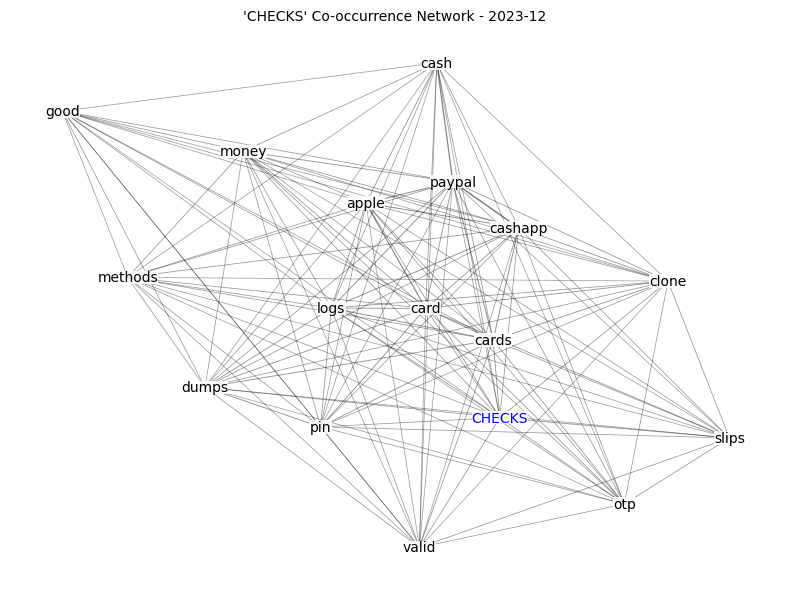


Network for 'checks' (2023-12):
Nodes: 17 | Edges: 150
Top connections: slips (3499), cards (2338), valid (1808)


In [141]:
if __name__ == "__main__":
    # Test file structure first
    #test_file_structure()
    
    # Run single-term analysis with rectangles (uncomment when ready)
    single_term_analysis()
    
    # Or run the original multi-term analysis
    # main()